# Importing Necessary Libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
## Importing Dataset

In [53]:
data_train = pd.read_csv("fashion-mnist_train.csv")
data_test = pd.read_csv("fashion-mnist_test.csv")

"mean = data_train.mean()\nstd = data_train.std()\ndata_train_std = (data_train - mean)/std\ndata_test_std = (data_test - mean)/std    \nprint(data_train_std.shape)\nprint(data_test_std.shape)\nprint(data_train_std['label'].nunique())\n"

## Standardizing and Train-Val-Test Split

In [54]:
X_full = data_train.drop('label', axis=1)
y_full = data_train['label']
X_test = data_test.drop('label', axis=1)
y_test = data_test['label']
mean = X_full.mean()
std = X_full.std()
X_full = (X_full-mean)/std
X_test = (X_test-mean)/std
np.random.seed(42)
n_samples = len(X_full)
n_val = int(n_samples * 0.1)

# Generate random indices
indices = np.random.permutation(n_samples)
val_indices = indices[:n_val]
train_indices = indices[n_val:]

# Split the data
X_train = X_full.iloc[train_indices]
X_val = X_full.iloc[val_indices]
y_train = y_full.iloc[train_indices]
y_val = y_full.iloc[val_indices]
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values
y_train_onehot = pd.get_dummies(y_train).values
y_val_onehot = pd.get_dummies(y_val).values
y_test_onehot = pd.get_dummies(y_test).values

# Creation of Neural Network
## Implementation of single layer

In [55]:
class Layer:
    def __init__(self, n_inputs, n_neurons, activation='relu', optimizer = 'gd'):
        self.weights = np.random.normal(0, np.sqrt(2.0/n_inputs), size=(n_inputs, n_neurons)) # He Initializaion
        self.biases = np.zeros((1, n_neurons))
        self.activation = activation
        self.optimizer = optimizer
    def forward(self, inputs):
        self.inputs = inputs
        self.z = np.dot(inputs, self.weights) + self.biases
        if self.activation == 'relu':
            self.output = np.maximum(0, self.z)
        elif self.activation == 'softmax':
            exp_values = np.exp(self.z - np.max(self.z, axis=1, keepdims=True))
            self.output = exp_values / (np.sum(exp_values, axis=1, keepdims=True) + 1e-15)
        return self.output
    def backward(self,d_output, learning_rate):
        if self.activation == 'relu':
            d_activation = np.where(self.z > 0, 1, 0)
        if self.activation == 'softmax':
            d_activation = 1
        d_z = d_output*d_activation
        d_weights = np.dot(self.inputs.T, d_z)
        d_biases = np.sum(d_z, axis=0, keepdims=True)
        d_inputs = np.dot(d_z, self.weights.T)
        if self.optimizer == 'gd':
            self.weights -= learning_rate * d_weights
            self.biases -= learning_rate * d_biases
        return d_inputs

## Creating class Neural Network to join together Layers

In [64]:
class NeuralNetwork:
    def __init__(self):
        self.layers = []
        self.loss_history = []
        self.train_valgap = []
    def add_layer(self, n_inputs, n_neurons, activation='relu'):
        self.layers.append(Layer(n_inputs, n_neurons, activation))
    def forward(self, X):
        current_output = X
        for layer in self.layers:
            current_output = layer.forward(current_output)
        return current_output
    def compute_loss(self, y_pred, y_true):
        epsilon = 1e-15  # Small constant to prevent log(0)
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip predictions
        loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))  # Compute loss
        return loss
    def compute_accuracy(self, y_pred, y_true):
        predictions = np.argmax(y_pred, axis=1)
        truth = np.argmax(y_true, axis=1)
        return np.mean(predictions == truth)
    def backward(self, y_pred, y_true, learning_rate):
        d_output = y_pred - y_true
        for layer in reversed(self.layers):
            d_output = layer.backward(d_output, learning_rate)
    def train(self,X,y,epochs=30,batch_size=64,learning_rate=0.03):
        n_samples = len(X)
        for epoch in range(epochs):
            for i in range(0, n_samples, batch_size):
                X_batch = X[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                
                # Forward pass
                y_pred = self.forward(X_batch)
                
                # Compute loss
                loss = self.compute_loss(y_pred, y_batch)
                self.loss_history.append(loss)
                
                # Backward pass
                self.backward(y_pred, y_batch, learning_rate)
            
            # Print progress every 5 epochs
            if (epoch + 1) % 5 == 0:
                y_pred = self.forward(X)
                accuracy = self.compute_accuracy(y_pred, y)
                print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')
                val_predictions = self.forward(X_val)
                val_accuracy = self.compute_accuracy(val_predictions, y_val_onehot)
        return self.loss_history

## Creating model Architecture

In [57]:
n_features = X_train.shape[1]
n_classes = y_train_onehot.shape[1]
Neuralnetmodel = NeuralNetwork()
Neuralnetmodel.add_layer(n_features, 64, 'relu')    # Input layer -> Hidden layer
Neuralnetmodel.add_layer(64, 32, 'relu')            # Hidden layer -> Hidden layer
Neuralnetmodel.add_layer(32, n_classes, 'softmax')   # Hidden layer -> Output layer
loss_history = Neuralnetmodel.train( X_train, y_train_onehot,batch_size=32,
        learning_rate=0.002)  

Epoch 5/30, Loss: 0.2305, Accuracy: 0.8982
Validation Accuracy: 0.8713
Epoch 10/30, Loss: 0.2365, Accuracy: 0.9178
Validation Accuracy: 0.8757
Epoch 15/30, Loss: 0.1431, Accuracy: 0.9296
Validation Accuracy: 0.8760
Epoch 20/30, Loss: 0.1052, Accuracy: 0.9317
Validation Accuracy: 0.8748
Epoch 25/30, Loss: 0.0451, Accuracy: 0.9281
Validation Accuracy: 0.8653
Epoch 30/30, Loss: 0.0772, Accuracy: 0.9413
Validation Accuracy: 0.8717


# Final Test

In [58]:
test_predictions = Neuralnetmodel.forward(X_test)
test_accuracy = Neuralnetmodel.compute_accuracy(test_predictions, y_test_onehot)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8698


# Visualizations

## Misclassifications vs image

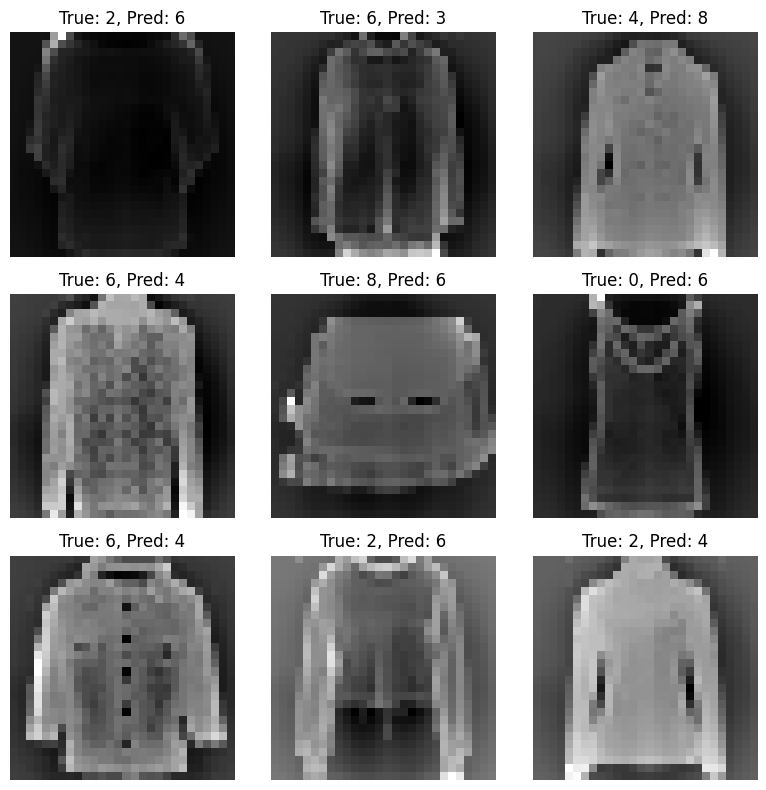

In [60]:
misclassified = np.where(y_pred != y_test)[0]
fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat[:9]):
    ax.imshow(X_test[misclassified[i]].reshape(28, 28), cmap='gray')
    ax.set_title(f'True: {y_test.iloc[misclassified[i]]}, Pred: {y_pred[misclassified[i]]}')
    ax.axis('off')
plt.tight_layout()
plt.show()